In [1]:
import requests
from typing import List, Dict
import os
from dotenv import load_dotenv

# Load environment variables from .env (install python-dotenv if needed: pip install python-dotenv)
load_dotenv()  # reads .env from project root

# Configuration
FMP_API_BASE_URL = "https://financialmodelingprep.com/api/v3"
# Accept either API_KEY or FMP_API_KEY in the .env for flexibility
API_KEY = os.getenv("API_KEY") or os.getenv("FMP_API_KEY")
if not API_KEY:
    raise RuntimeError("FMP API key not found. Set API_KEY or FMP_API_KEY in your .env file.")

In [2]:
import pandas as pd

In [3]:
class Company:
    """A class representing company details."""
    def __init__(self, ticker: str, name: str, market_cap: int, country: str, sector: str, industry: str):
        self.ticker = ticker
        self.name = name
        self.market_cap = market_cap
        self.country = country
        self.sector = sector
        self.industry = industry

    def __repr__(self):
        return f"Company(ticker='{self.ticker}', name='{self.name}', market_cap={self.market_cap}, country='{self.country}', sector='{self.sector}', industry='{self.industry}')"

def get_companies() -> list[Company]:
    """
    Fetches a list of AI, self-driving cars, and semiconductor-related small-cap companies.
    Returns a list of Company objects.
    """
    try:
        # Set up query parameters
        params = {
            "marketCapMoreThan": 100_000_000_000,  # Minimum $100B
            "marketCapLowerThan": 20_000_000_000_000,  # Maximum $20T
            "country": "US",  # Only companies based in the US
            "exchange": "NASDAQ,NYSE",  # Only companies traded on US exchanges
            "isActivelyTrading": "true",
            "limit": 1000,
            "apikey": API_KEY,
        }

        # Make API call
        response = requests.get(f"{FMP_API_BASE_URL}/stock-screener", params=params)
        response.raise_for_status()

        data = response.json()

        if not isinstance(data, list):
            raise ValueError("Invalid response format")

        if not data:
            print("Warning: No companies found matching criteria.")

        companies = [
            Company(
                ticker=company.get("symbol"),
                name=company.get("companyName"),
                market_cap=company.get("marketCap"),
                country=company.get("country"),
                sector=company.get("sector"),
                industry=company.get("industry"),
            )
            for company in data
            if company.get("exchangeShortName") in {"NASDAQ", "NYSE"}  # Additional safety filter
        ]

        return companies

    except requests.RequestException as error:
        print(f"Company fetch error: {error}")
        raise Exception("Failed to fetch companies") from error

# Fetch and display companies
companies = get_companies()
for company in companies:
    print(company)

Company(ticker='NVDA', name='NVIDIA Corporation', market_cap=4585027040000, country='US', sector='Technology', industry='Semiconductors')
Company(ticker='MSFT', name='Microsoft Corporation', market_cap=3821019177125, country='US', sector='Technology', industry='Software - Infrastructure')
Company(ticker='AAPL', name='Apple Inc.', market_cap=3675370987400, country='US', sector='Technology', industry='Consumer Electronics')
Company(ticker='GOOG', name='Alphabet Inc.', market_cap=2958816134690, country='US', sector='Communication Services', industry='Internet Content & Information')
Company(ticker='GOOGL', name='Alphabet Inc.', market_cap=2952889794329, country='US', sector='Communication Services', industry='Internet Content & Information')
Company(ticker='AMZN', name='Amazon.com, Inc.', market_cap=2347027205187, country='US', sector='Consumer Cyclical', industry='Specialty Retail')
Company(ticker='VTSAX', name='Vanguard Total Stock Market Index Fund', market_cap=2049729823410, country='

In [4]:
len(companies)

226

In [5]:
all_results = []
for comp in companies:
    temp = {'ticker': comp.ticker,
            'name': comp.name,
            'market_cap': comp.market_cap,
            'sector': comp.sector,
            'industry': comp.industry}
    all_results.append(temp)

results_df = pd.DataFrame(all_results)

In [6]:
results_df.head()

,ticker,name,market_cap,sector,industry
0,NVDA,NVIDIA Corporation,4235647590000,Technology,Semiconductors
1,MSFT,Microsoft Corporation,3768095032506,Technology,Software - Infrastructure
2,AAPL,Apple Inc.,3749869745200,Technology,Consumer Electronics
3,GOOG,Alphabet Inc.,2932570913090,Communication Services,Internet Content & Information
4,GOOGL,Alphabet Inc.,2921927689584,Communication Services,Internet Content & Information


In [7]:
def get_stock_price_data(ticker: str, days: int = 100) -> pd.DataFrame:
    """
    Fetches historical daily stock price data for a given ticker.

    :param ticker: Stock ticker symbol
    :param days: Number of most recent days to fetch
    :return: DataFrame with historical price data (OHLC)
    """
    try:
        url = f"{FMP_API_BASE_URL}/historical-price-full/{ticker}"
        params = {
            "timeseries": days,
            "apikey": API_KEY
        }
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if "historical" not in data:
            raise ValueError(f"No historical data found for {ticker}")

        df = pd.DataFrame(data["historical"])
        df['ticker'] = ticker
        return df

    except requests.RequestException as error:
        print(f"Error fetching data for {ticker}: {error}")
        return pd.DataFrame()
    
# Collect price data for all companies in the list
all_price_data = None  # Will become the merged DataFrame

for company in companies:
    print(f"Fetching data for {company.ticker}...")
    df = get_stock_price_data(company.ticker, days=400)

    if not df.empty:
        df = df[['date', 'open', 'close']].copy()
        df.rename(columns={
            'open': f'{company.ticker}_open',
            'close': f'{company.ticker}_close'
        }, inplace=True)

        # Add market cap as a constant column
        df[f'{company.ticker}_market_cap'] = company.market_cap

        # Merge with existing data by date
        if all_price_data is None:
            all_price_data = df
        else:
            all_price_data = pd.merge(all_price_data, df, on='date', how='outer')

# Final touch: sort by date
if all_price_data is not None:
    all_price_data.sort_values(by='date', inplace=True)
    all_price_data.reset_index(drop=True, inplace=True)

# Preview
print(all_price_data.head())


Fetching data for NVDA...
Fetching data for MSFT...


Fetching data for AAPL...
Fetching data for GOOG...
Fetching data for GOOGL...
Fetching data for VSMPX...
Fetching data for AMZN...
Fetching data for META...
Fetching data for AVGO...
Fetching data for TSLA...
Fetching data for VFINX...
Fetching data for VFIAX...
Fetching data for VFFSX...
Fetching data for VITSX...
Fetching data for VTSAX...
Fetching data for BRK-A...
Fetching data for BRK-B...
Fetching data for JPM...
Fetching data for WMT...
Fetching data for ORCL...
Fetching data for FXAIX...
Fetching data for LLY...
Fetching data for V...
Fetching data for VTPSX...
Fetching data for VTSNX...
Fetching data for VTIAX...
Fetching data for VXUS...
Fetching data for MA...
Fetching data for NFLX...
Fetching data for XOM...
Fetching data for JNJ...
Fetching data for COST...
Fetching data for HD...
Fetching data for PLTR...
Fetching data for ABBV...
Fetching data for BAC...
Fetching data for VBMPX...
Fetching data for VBMFX...
Fetching data for VBTLX...
Fetching data for VBTIX...
Fetching

In [8]:
all_price_data.head()

,date,NVDA_open,NVDA_close,NVDA_market_cap,MSFT_open,MSFT_close,MSFT_market_cap,AAPL_open,AAPL_close,AAPL_market_cap,...,VTHRX_market_cap,CEG_open,CEG_close,CEG_market_cap,VFORX_open,VFORX_close,VFORX_market_cap,VTIVX_open,VTIVX_close,VTIVX_market_cap
0,2024-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,132.29,131.40,1.034125e+11,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-22,75.03,78.54,4.235648e+12,410.19,411.65,3.768095e+12,183.48,184.37,3.749870e+12,...,1.040000e+11,132.40,133.39,1.034125e+11,40.46,40.46,1.025228e+11,27.57,27.57,1.018114e+11
2,2024-02-23,80.79,78.82,4.235648e+12,415.67,410.34,3.768095e+12,185.01,182.52,3.749870e+12,...,1.040000e+11,133.49,133.99,1.034125e+11,40.52,40.52,1.025228e+11,27.60,27.60,1.018114e+11
3,2024-02-26,79.70,79.09,4.235648e+12,411.46,407.54,3.768095e+12,182.24,181.16,3.749870e+12,...,1.040000e+11,134.68,133.22,1.034125e+11,40.42,40.42,1.025228e+11,27.53,27.53,1.018114e+11
4,2024-02-27,79.38,78.70,4.235648e+12,407.99,407.48,3.768095e+12,181.10,182.63,3.749870e+12,...,1.040000e+11,135.00,155.76,1.034125e+11,40.48,40.48,1.025228e+11,27.58,27.58,1.018114e+11


In [9]:
all_price_data.columns

Index(['date', 'NVDA_open', 'NVDA_close', 'NVDA_market_cap', 'MSFT_open',
       'MSFT_close', 'MSFT_market_cap', 'AAPL_open', 'AAPL_close',
       'AAPL_market_cap',
       ...
       'VTHRX_market_cap', 'CEG_open', 'CEG_close', 'CEG_market_cap',
       'VFORX_open', 'VFORX_close', 'VFORX_market_cap', 'VTIVX_open',
       'VTIVX_close', 'VTIVX_market_cap'],
      dtype='object', length=679)

In [10]:
all_price_data.to_csv('all_price_data_check_v2.csv', index = False)

In [11]:
all_price_data = pd.read_csv('all_price_data_check_v2.csv')

In [12]:
# Define moving average windows
ma_windows = [5, 10, 30, 180, 360]

# Identify open columns (e.g., AAPL_open, MSFT_open, etc.)
open_columns = [col for col in all_price_data.columns if col.endswith('_open')]

# Calculate moving averages for each company
for col in open_columns:
    ticker = col.replace('_open', '')
    for window in ma_windows:
        ma_col = f'{ticker}_MA_{window}'
        all_price_data[ma_col] = all_price_data[col].rolling(window=window).mean()

/tmp/ipykernel_3604/4023690687.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_price_data[ma_col] = all_price_data[col].rolling(window=window).mean()
/tmp/ipykernel_3604/4023690687.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_price_data[ma_col] = all_price_data[col].rolling(window=window).mean()
/tmp/ipykernel_3604/4023690687.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

In [13]:
all_price_data.head()

,date,NVDA_open,NVDA_close,NVDA_market_cap,MSFT_open,MSFT_close,MSFT_market_cap,AAPL_open,AAPL_close,AAPL_market_cap,...,VFORX_MA_5,VFORX_MA_10,VFORX_MA_30,VFORX_MA_180,VFORX_MA_360,VTIVX_MA_5,VTIVX_MA_10,VTIVX_MA_30,VTIVX_MA_180,VTIVX_MA_360
0,2024-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-22,75.03,78.54,4.235648e+12,410.19,411.65,3.768095e+12,183.48,184.37,3.749870e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-02-23,80.79,78.82,4.235648e+12,415.67,410.34,3.768095e+12,185.01,182.52,3.749870e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-02-26,79.70,79.09,4.235648e+12,411.46,407.54,3.768095e+12,182.24,181.16,3.749870e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-02-27,79.38,78.70,4.235648e+12,407.99,407.48,3.768095e+12,181.10,182.63,3.749870e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
check_stock = 'BA'
all_price_data[['date',f'{check_stock}_open', f'{check_stock}_MA_5', f'{check_stock}_MA_10', f'{check_stock}_MA_30', f'{check_stock}_MA_180', f'{check_stock}_MA_360']]

,date,BA_open,BA_MA_5,BA_MA_10,BA_MA_30,BA_MA_180,BA_MA_360
0,2024-02-21,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-22,202.00,NaN,NaN,NaN,NaN,NaN
2,2024-02-23,200.99,NaN,NaN,NaN,NaN,NaN
3,2024-02-26,201.01,NaN,NaN,NaN,NaN,NaN
4,2024-02-27,200.93,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
396,2025-09-19,217.73,216.332,222.186,228.172000,195.443167,181.769556
397,2025-09-22,215.17,216.116,220.533,227.761000,195.652222,181.892972
398,2025-09-23,217.12,216.168,219.144,227.365000,195.867833,182.029028
399,2025-09-24,217.56,216.562,217.940,227.052000,196.124278,182.161139


### Portfolio check

In [15]:
# Settings
cut_off_date = '2025-06-09'
initial_fund = 3000
per_stock_max_investment = 1500
max_stock = 5
hold_period = 5

# test_data = all_price_data[all_price_data['date'] >= '2025-04-01']

Summary of Your Rules:
Capital: $10,000 starting fund.

Max holdings: 5 stocks.

Holding period: Buy day T, sell at open price on day T+11.

Buy condition: Open price < MA360 and MA10.

Random selection if >5 eligible stocks.

Investment cap: Max $5,000 per stock.

Whole shares only.

Track daily portfolio value

In [16]:
import random
import pandas as pd

# exclusion_list = {'VBMPX', 'VBMFX', 'VBTLX', 'VTBNX'}

def run_backtest(
    data: pd.DataFrame,
    cut_off_date: str,
    initial_fund: float = 10000,
    per_stock_max_investment: float = 5000,
    max_stock: int = 5,
    hold_period: int = 5,
    ma_short: int = 10,
    ma_long: int = 360,
    prefer_high_market_cap: bool = True  # <-- New parameter
):
    # Define exclusion list
    exclusion_list = {'VBMPX', 'VBMFX', 'VBTLX', 'VTBNX', 'VSCIX'}

    # Filter and sort test data
    test_data = data[data['date'] >= cut_off_date].copy()
    test_data['date'] = pd.to_datetime(test_data['date'])
    test_data.sort_values('date', inplace=True)
    unique_dates = test_data['date'].unique()

    # Trackers
    cash = initial_fund
    portfolio = []
    portfolio_history = []
    trade_log = []
    all_candidates_log = []  # <-- NEW

    # Get list of tickers
    tickers = list(set(col.replace('_open', '') for col in test_data.columns if col.endswith('_open')))

    for current_date in unique_dates:
        today_data = test_data[test_data['date'] == current_date]

        # --- Sell logic ---
        new_portfolio = []
        for holding in portfolio:
            held_days = (current_date - holding['buy_date']).days
            if held_days >= hold_period:
                sell_price = today_data[f"{holding['ticker']}_open"].values[0]
                proceeds = sell_price * holding['shares']
                cash += proceeds
            else:
                new_portfolio.append(holding)
        portfolio = new_portfolio

        # --- Buy logic ---
        available_slots = max_stock - len(portfolio)
        if available_slots > 0:
            candidates = []
            for ticker in tickers:
                if ticker in exclusion_list:
                    continue  # Skip excluded tickers

                try:
                    open_price = today_data[f"{ticker}_open"].values[0]
                    ma_s = today_data[f"{ticker}_MA_{ma_short}"].values[0]
                    ma_l = today_data[f"{ticker}_MA_{ma_long}"].values[0]
                    market_cap = today_data[f"{ticker}_market_cap"].values[0]

                    if pd.notna(open_price) and pd.notna(ma_s) and pd.notna(ma_l) and pd.notna(market_cap):
                        if open_price < ma_s and open_price < ma_l:
                            candidate_info = {
                                'date': current_date,
                                'ticker': ticker,
                                'open_price': open_price,
                                'market_cap': market_cap,
                                'ma_short': ma_s,
                                'ma_long': ma_l
                            }
                            candidates.append(candidate_info)
                            all_candidates_log.append(candidate_info)  # <-- Log all candidates
                except KeyError:
                    continue

            if candidates:
                candidates.sort(
                    key=lambda x: x['market_cap'],
                    reverse=prefer_high_market_cap
                )

                for candidate in candidates:
                    if len(portfolio) >= max_stock or cash < candidate['open_price']:
                        break

                    max_invest = min(per_stock_max_investment, cash)
                    shares = int(max_invest // candidate['open_price'])

                    if shares > 0:
                        spent = shares * candidate['open_price']
                        cash -= spent
                        portfolio.append({
                            'ticker': candidate['ticker'],
                            'buy_date': current_date,
                            'buy_price': candidate['open_price'],
                            'shares': shares
                        })
                        trade_log.append({
                            'date': current_date,
                            'ticker': candidate['ticker'],
                            'buy_price': candidate['open_price'],
                            'ma_short': candidate['ma_short'],
                            'ma_long': candidate['ma_long'],
                            'shares': shares,
                            'invested': spent
                        })

        # --- Portfolio value ---
        value = cash
        for holding in portfolio:
            try:
                current_price = today_data[f"{holding['ticker']}_open"].values[0]
                value += current_price * holding['shares']
            except KeyError:
                continue

        portfolio_history.append({
            'date': current_date,
            'cash': cash,
            'portfolio_value': value,
            'stocks_held': len(portfolio)
        })

    return (
        pd.DataFrame(portfolio_history),
        pd.DataFrame(trade_log),
        pd.DataFrame(all_candidates_log)  # <-- Return candidates log
    )


# Convert to DataFrame
portfolio_df, trades_df, candidates_df = run_backtest(
    all_price_data,
    cut_off_date='2025-09-25',
    initial_fund = 10000,
    per_stock_max_investment = 1500,
    max_stock= 10,
    hold_period = 5,
    ma_short=10,
    ma_long=360,
    prefer_high_market_cap = True
)

# Plot or analyze
print(trades_df)# print(portfolio_df.tail())


        date ticker  buy_price  ma_short     ma_long  shares  invested
0 2025-09-25     KO     66.405   66.5655   67.367292      22   1460.91
1 2025-09-25    CRM    244.500  244.7210  278.600889       6   1467.00
2 2025-09-25    MRK     79.780   81.3280  100.381000      18   1436.04
3 2025-09-25    TMO    467.900  476.3460  522.602694       3   1403.70
4 2025-09-25   ISRG    440.000  441.9000  493.918694       3   1320.00
5 2025-09-25   AMGN    279.000  279.3040  298.994639       5   1395.00
6 2025-09-25   ADBE    351.910  358.6590  450.211528       4   1407.64


In [17]:
portfolio_df

,date,cash,portfolio_value,stocks_held
0,2025-09-25,109.71,10000.0,7


In [18]:
candidates_df

,date,ticker,open_price,market_cap,ma_short,ma_long
0,2025-09-25,KO,66.405,2.872913e+11,66.5655,67.367292
1,2025-09-25,SPGI,489.330,1.490368e+11,522.4140,499.115833
2,2025-09-25,NKE,70.670,1.042571e+11,72.2440,75.906861
3,2025-09-25,BNH,16.300,0.000000e+00,16.7850,16.923472
4,2025-09-25,MRK,79.780,1.991732e+11,81.3280,100.381000
5,2025-09-25,HON,208.900,1.325823e+11,210.7740,214.081917
6,2025-09-25,PFE,24.170,1.368228e+11,24.1760,26.370528
7,2025-09-25,CRM,244.500,2.321000e+11,244.7210,278.600889
8,2025-09-25,ADBE,351.910,1.493905e+11,358.6590,450.211528
9,2025-09-25,ISRG,440.000,1.559444e+11,441.9000,493.918694


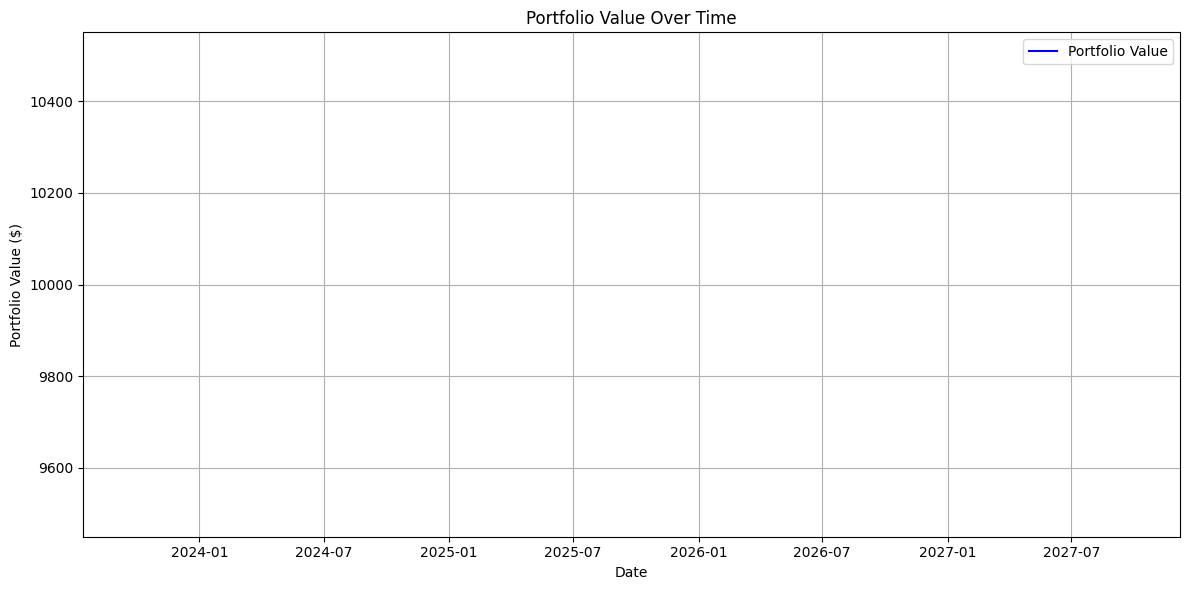

In [19]:
import matplotlib.pyplot as plt

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['date'], portfolio_df['portfolio_value'], label='Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Calculate daily returns
portfolio_df['daily_return'] = portfolio_df['portfolio_value'].pct_change()

# Drop NaN from first row
daily_returns = portfolio_df['daily_return'].dropna()

# Calculate Sharpe Ratio (annualized assuming 252 trading days)
risk_free_rate = 0.0
sharpe_ratio = ((daily_returns.mean() - risk_free_rate) / daily_returns.std()) * (252**0.5)

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: nan
